In [1]:
import numpy as np
from model_aug_shiftx import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/shiftx_NoAug_argminW_lr0.0002/checkpoint"
sample_dir = "./out/shiftx_NoAug_argminW_lr0.0002/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

loading mnist...
 [*] Reading checkpoints... ./out/shiftx_NoAug_argminW_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from ./out/shiftx_NoAug_argminW_lr0.0002/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


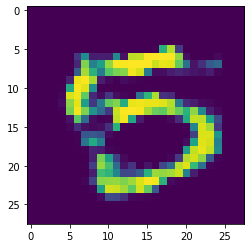

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    if alpha == 0:
        return outputs_zs, mask_fn
    
    M = np.float32([[1,0,alpha],[0,1,0]])
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
        
    if show_img:
        print('Target image:')
#         imshow_unscaled(target_fn)
        imshow(target_fn[0,:,:,0], im_size=128)
    if show_mask:
        print('Target mask:')
#         imshow_unscaled(mask_out)
        imshow(mask_out[0,:,:,0], im_size=128)

    return target_fn, mask_out

In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/walk_train_aug/shiftx_l2_git{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 6)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)
#             Loss_sum = Loss_sum + curr_loss
#             loss_values.append(curr_loss)

#             elapsed_time = time.time() - start_time

#             logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))
                
#             alpha_list.append(alpha_val)

#             if (optim_iter % 100 == 0) and (optim_iter > 0):
#                 saver.save(sess, './shift_l2_git/model_{}.ckpt'.format(optim_iter*batch_size), write_meta_graph=False, write_state=False)

#             optim_iter = optim_iter+1
            
#     if optim_iter > 0:
#         print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
#     saver.save(sess, "./shift_l2_git/model_{}_final.ckpt".format(optim_iter*batch_size), write_meta_graph=False, write_state=False)
#     return loss_values
            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-16 22:54:10,334 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.2107682228088379, 0, 0, 0.18183694779872894, 3
2019-09-16 22:54:10,344 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00803828239440918, 0, 10, 0.23026977479457855, -4
2019-09-16 22:54:10,353 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008384466171264648, 0, 20, 0.0821366012096405, 1
2019-09-16 22:54:10,364 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010089635848999023, 0, 30, 0.19728638231754303, -3
2019-09-16 22:54:10,375 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009628534317016602, 0, 40, 0.2384987324476242, 5
2019-09-16 22:54:10,385 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008955001831054688, 0, 50, 0.16850177943706512, -2
2019-09-16 22:54:10,396 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009720563888549805, 0, 60, 0.17963241040706635, -3
2019-09-16 22:54:10,407 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009257793426513672, 0, 70, 0.2158990502357483, -5
2019-09-16 22:54:10,418 [MainThrea

2019-09-16 22:54:11,030 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008453130722045898, 0, 680, 0.13696768879890442, 3
2019-09-16 22:54:11,040 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008713006973266602, 0, 690, 0.15304648876190186, -5
2019-09-16 22:54:11,050 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008608341217041016, 0, 700, 0.036714740097522736, 1
2019-09-16 22:54:11,060 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00865936279296875, 0, 710, 0.03356412798166275, -1
2019-09-16 22:54:11,074 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013296842575073242, 0, 720, 0.10141551494598389, 2
2019-09-16 22:54:11,085 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009336233139038086, 0, 730, 0.17286711931228638, 4
2019-09-16 22:54:11,095 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009556770324707031, 0, 740, 0.03664844483137131, 1
2019-09-16 22:54:11,106 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009614944458007812, 0, 750, 0.14538736641407013, -4
2019-09-16 22:54:11,1

2019-09-16 22:54:11,728 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008921146392822266, 0, 1350, 0.02855870872735977, -1
2019-09-16 22:54:11,738 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00848078727722168, 0, 1360, 0.20948317646980286, 5
2019-09-16 22:54:11,748 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009173154830932617, 0, 1370, 0.158808171749115, -5
2019-09-16 22:54:11,758 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009360074996948242, 0, 1380, 0.1171184703707695, 3
2019-09-16 22:54:11,768 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008824348449707031, 0, 1390, 0.1491328328847885, 4
2019-09-16 22:54:11,779 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008961200714111328, 0, 1400, 0.0816158726811409, 2
2019-09-16 22:54:11,789 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009353399276733398, 0, 1410, 0.06500650942325592, -2
2019-09-16 22:54:11,799 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008693456649780273, 0, 1420, 0.16366983950138092, 5
2019-09-16 22:54:11

2019-09-16 22:54:12,403 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008851289749145508, 0, 2020, 0.06676983833312988, 2
2019-09-16 22:54:12,413 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008686304092407227, 0, 2030, 0.10846894234418869, -3
2019-09-16 22:54:12,423 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008893251419067383, 0, 2040, 0.17418864369392395, -5
2019-09-16 22:54:12,432 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008521080017089844, 0, 2050, 0.09898880124092102, -3
2019-09-16 22:54:12,442 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009015798568725586, 0, 2060, 0.15805047750473022, 5
2019-09-16 22:54:12,453 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009168148040771484, 0, 2070, 0.1638234257698059, -5
2019-09-16 22:54:12,463 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008829832077026367, 0, 2080, 0.16088446974754333, 5
2019-09-16 22:54:12,473 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008898496627807617, 0, 2090, 0.17952369153499603, 5
2019-09-16 22

2019-09-16 22:54:13,097 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008977413177490234, 0, 2690, 0.02868448942899704, 1
2019-09-16 22:54:13,107 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008654594421386719, 0, 2700, 0.1408955156803131, -4
2019-09-16 22:54:13,117 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00865483283996582, 0, 2710, 0.02653888612985611, 1
2019-09-16 22:54:13,127 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008882761001586914, 0, 2720, 0.1764933466911316, -5
2019-09-16 22:54:13,137 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009174585342407227, 0, 2730, 0.09594625234603882, -3
2019-09-16 22:54:13,147 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008584022521972656, 0, 2740, 0.1628379374742508, -5
2019-09-16 22:54:13,157 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008829355239868164, 0, 2750, 0.0984620675444603, 3
2019-09-16 22:54:13,166 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008316278457641602, 0, 2760, 0.15484105050563812, 5
2019-09-16 22:54:

2019-09-16 22:54:13,767 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008463621139526367, 0, 3350, 0.027517231181263924, -1
2019-09-16 22:54:13,777 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008871078491210938, 0, 3360, 0.1567913293838501, -5
2019-09-16 22:54:13,787 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009276390075683594, 0, 3370, 0.07990505546331406, 2
2019-09-16 22:54:13,797 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00910329818725586, 0, 3380, 0.11930359899997711, 3
2019-09-16 22:54:13,808 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00957798957824707, 0, 3390, 0.15532004833221436, 5
2019-09-16 22:54:13,819 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009149789810180664, 0, 3400, 0.028887443244457245, 1
2019-09-16 22:54:13,829 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008755207061767578, 0, 3410, 0.1068347841501236, 3
2019-09-16 22:54:13,839 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008623838424682617, 0, 3420, 0.09802490472793579, -3
2019-09-16 22:5

2019-09-16 22:54:14,455 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008822441101074219, 0, 4010, 0.10714884102344513, 3
2019-09-16 22:54:14,465 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008826494216918945, 0, 4020, 0.06392963975667953, -2
2019-09-16 22:54:14,475 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008842229843139648, 0, 4030, 0.11561593413352966, -4
2019-09-16 22:54:14,485 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008784770965576172, 0, 4040, 0.029500657692551613, 1
2019-09-16 22:54:14,496 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009497880935668945, 0, 4050, 0.13127264380455017, -5
2019-09-16 22:54:14,507 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009438753128051758, 0, 4060, 0.026109891012310982, -1
2019-09-16 22:54:14,517 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00877237319946289, 0, 4070, 0.15060913562774658, 5
2019-09-16 22:54:14,527 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008997678756713867, 0, 4080, 0.05727001652121544, 2
2019-09-16 

2019-09-16 22:54:15,144 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009308576583862305, 0, 4680, 0.11940574645996094, 4
2019-09-16 22:54:15,156 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010642290115356445, 0, 4690, 0.12676483392715454, -4
2019-09-16 22:54:15,167 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009077072143554688, 0, 4700, 0.10978714376688004, -3
2019-09-16 22:54:15,177 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009629964828491211, 0, 4710, 0.1378408819437027, 5
2019-09-16 22:54:15,189 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009931564331054688, 0, 4720, 0.10878713428974152, -4
2019-09-16 22:54:15,198 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008793115615844727, 0, 4730, 0.023240117356181145, 1
2019-09-16 22:54:15,209 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009372472763061523, 0, 4740, 0.05321814492344856, 2
2019-09-16 22:54:15,219 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008939266204833984, 0, 4750, 0.07853428274393082, 3
2019-09-16 22

2019-09-16 22:54:15,815 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009708404541015625, 0, 5340, 0.028022225946187973, -1
2019-09-16 22:54:15,826 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009944915771484375, 0, 5350, 0.0562477633357048, 2
2019-09-16 22:54:15,837 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009292125701904297, 0, 5360, 0.1055651530623436, 4
2019-09-16 22:54:15,846 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008252143859863281, 0, 5370, 0.1389668583869934, 5
2019-09-16 22:54:15,856 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008990764617919922, 0, 5380, 0.0836639478802681, 3
2019-09-16 22:54:15,866 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008789539337158203, 0, 5390, 0.02337801083922386, -1
2019-09-16 22:54:15,876 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008776187896728516, 0, 5400, 0.056135959923267365, 2
2019-09-16 22:54:15,886 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008865833282470703, 0, 5410, 0.057546216994524, -2
2019-09-16 22:54:

Loss: [0.013078558694571257, 0.010522845970466732, 0.009815306657925248, 0.00984750838764012, 0.008521026020869613, 0.008165258193388581]
2019-09-16 22:54:16,499 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008647441864013672, 0, 6010, 0.08688824623823166, -3
2019-09-16 22:54:16,509 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009236335754394531, 0, 6020, 0.10571964830160141, 4
2019-09-16 22:54:16,520 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009440898895263672, 0, 6030, 0.02111802250146866, -1
2019-09-16 22:54:16,530 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009033203125, 0, 6040, 0.09574223309755325, 3
2019-09-16 22:54:16,540 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008837223052978516, 0, 6050, 0.049655310809612274, -2
2019-09-16 22:54:16,551 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009469270706176758, 0, 6060, 0.09991884231567383, 3
2019-09-16 22:54:16,561 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008654117584228516, 0, 6070, 0.04487252235412598, 2
201

2019-09-16 22:54:17,174 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008707761764526367, 0, 6670, 0.05611998587846756, 2
2019-09-16 22:54:17,184 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008729219436645508, 0, 6680, 0.1264326125383377, 4
2019-09-16 22:54:17,193 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008100748062133789, 0, 6690, 0.12174221873283386, -4
2019-09-16 22:54:17,203 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008836746215820312, 0, 6700, 0.1337035596370697, 4
2019-09-16 22:54:17,213 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00889897346496582, 0, 6710, 0.08170571178197861, -3
2019-09-16 22:54:17,223 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009094715118408203, 0, 6720, 0.10683176666498184, -4
2019-09-16 22:54:17,234 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009665250778198242, 0, 6730, 0.13582852482795715, 5
2019-09-16 22:54:17,245 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009113550186157227, 0, 6740, 0.08074939996004105, -3
2019-09-16 22:5

2019-09-16 22:54:17,853 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008799314498901367, 0, 7330, 0.0867810770869255, 3
2019-09-16 22:54:17,863 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008849620819091797, 0, 7340, 0.018051180988550186, -1
2019-09-16 22:54:17,873 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008699178695678711, 0, 7350, 0.13781239092350006, 5
2019-09-16 22:54:17,883 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009041070938110352, 0, 7360, 0.054037775844335556, -2
2019-09-16 22:54:17,893 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00914144515991211, 0, 7370, 0.1031765416264534, -4
2019-09-16 22:54:17,904 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009197711944580078, 0, 7380, 0.13039326667785645, -5
2019-09-16 22:54:17,914 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008983612060546875, 0, 7390, 0.02569885365664959, -1
2019-09-16 22:54:17,924 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00917506217956543, 0, 7400, 0.11322404444217682, -4
2019-09-16 2

2019-09-16 22:54:18,527 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00892186164855957, 0, 8000, 0.02188405580818653, 1
Loss: [0.013078558694571257, 0.010522845970466732, 0.009815306657925248, 0.00984750838764012, 0.008521026020869613, 0.008165258193388581, 0.00806252621859312, 0.008451648101210595]
2019-09-16 22:54:18,538 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008895158767700195, 0, 8010, 0.05909677967429161, -2
2019-09-16 22:54:18,548 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008717060089111328, 0, 8020, 0.12063202261924744, -5
2019-09-16 22:54:18,558 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008962631225585938, 0, 8030, 0.09740135818719864, -4
2019-09-16 22:54:18,569 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009286642074584961, 0, 8040, 0.1001153513789177, 4
2019-09-16 22:54:18,579 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008919954299926758, 0, 8050, 0.11144257336854935, 4
2019-09-16 22:54:18,589 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008581399

2019-09-16 22:54:19,209 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009654760360717773, 0, 8660, 0.1267070174217224, 5
2019-09-16 22:54:19,220 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009482860565185547, 0, 8670, 0.025427524000406265, 1
2019-09-16 22:54:19,231 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009788036346435547, 0, 8680, 0.1324678361415863, 5
2019-09-16 22:54:19,245 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013264894485473633, 0, 8690, 0.05223439633846283, -2
2019-09-16 22:54:19,255 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009194135665893555, 0, 8700, 0.07874540239572525, -3
2019-09-16 22:54:19,265 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008985042572021484, 0, 8710, 0.025320079177618027, 1
2019-09-16 22:54:19,275 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00888204574584961, 0, 8720, 0.026081247255206108, 1
2019-09-16 22:54:19,286 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009220361709594727, 0, 8730, 0.09203536808490753, 3
2019-09-16 22:

2019-09-16 22:54:19,873 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008869647979736328, 0, 9310, 0.02288421057164669, -1
2019-09-16 22:54:19,883 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008628606796264648, 0, 9320, 0.09545654058456421, -3
2019-09-16 22:54:19,893 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008938312530517578, 0, 9330, 0.04985697567462921, -2
2019-09-16 22:54:19,903 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008283853530883789, 0, 9340, 0.15620693564414978, -5
2019-09-16 22:54:19,913 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008645772933959961, 0, 9350, 0.11784537136554718, 4
2019-09-16 22:54:19,922 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008309364318847656, 0, 9360, 0.05265231430530548, -2
2019-09-16 22:54:19,933 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009354114532470703, 0, 9370, 0.027991369366645813, 1
2019-09-16 22:54:19,943 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00895071029663086, 0, 9380, 0.08173657208681107, 3
2019-09-16 

2019-09-16 22:54:20,552 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008380413055419922, 0, 9980, 0.13278232514858246, 5
2019-09-16 22:54:20,562 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0089263916015625, 0, 9990, 0.06934577971696854, 3
2019-09-16 22:54:20,572 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008845329284667969, 0, 10000, 0.08946970850229263, 3
Loss: [0.013078558694571257, 0.010522845970466732, 0.009815306657925248, 0.00984750838764012, 0.008521026020869613, 0.008165258193388581, 0.00806252621859312, 0.008451648101210595, 0.008085541101172567, 0.007926826624199749]
2019-09-16 22:54:20,582 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00888371467590332, 0, 10010, 0.05949580296874046, -2
2019-09-16 22:54:20,592 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008345842361450195, 0, 10020, 0.04878358170390129, -2
2019-09-16 22:54:20,602 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008736133575439453, 0, 10030, 0.04482893645763397, -2
2019-09-16 22:54:20,612 [MainThre

2019-09-16 22:54:21,210 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008684158325195312, 0, 10630, 0.05576413497328758, 2
2019-09-16 22:54:21,220 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008635520935058594, 0, 10640, 0.12179388105869293, 4
2019-09-16 22:54:21,230 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008711814880371094, 0, 10650, 0.05280863866209984, 2
2019-09-16 22:54:21,241 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009676456451416016, 0, 10660, 0.14316396415233612, 5
2019-09-16 22:54:21,251 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00923919677734375, 0, 10670, 0.027255617082118988, 1
2019-09-16 22:54:21,261 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008762121200561523, 0, 10680, 0.13774102926254272, 5
2019-09-16 22:54:21,271 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008701801300048828, 0, 10690, 0.14014694094657898, 5
2019-09-16 22:54:21,280 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0085906982421875, 0, 10700, 0.10429979860782623, -4
2019-09-1

2019-09-16 22:54:21,880 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00887751579284668, 0, 11270, 0.10577194392681122, 4
2019-09-16 22:54:21,890 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008783340454101562, 0, 11280, 0.12864342331886292, 4
2019-09-16 22:54:21,901 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009135723114013672, 0, 11290, 0.023502515628933907, -1
2019-09-16 22:54:21,911 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008848190307617188, 0, 11300, 0.02243896573781967, 1
2019-09-16 22:54:21,921 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009361743927001953, 0, 11310, 0.06483549624681473, -3
2019-09-16 22:54:21,932 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009130477905273438, 0, 11320, 0.05112610012292862, -2
2019-09-16 22:54:21,942 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009158849716186523, 0, 11330, 0.13956880569458008, -5
2019-09-16 22:54:21,952 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008737325668334961, 0, 11340, 0.02826729603111744, 1
2019

2019-09-16 22:54:22,560 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008780479431152344, 0, 11930, 0.053131602704524994, 2
2019-09-16 22:54:22,570 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008820772171020508, 0, 11940, 0.021734626963734627, 1
2019-09-16 22:54:22,580 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008959770202636719, 0, 11950, 0.15352573990821838, -5
2019-09-16 22:54:22,590 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009200096130371094, 0, 11960, 0.02348446287214756, -1
2019-09-16 22:54:22,601 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008951187133789062, 0, 11970, 0.1254688799381256, -5
2019-09-16 22:54:22,610 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008867502212524414, 0, 11980, 0.09189774096012115, 3
2019-09-16 22:54:22,621 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009174585342407227, 0, 11990, 0.02488822676241398, -1
2019-09-16 22:54:22,636 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014027118682861328, 0, 12000, 0.1041414886713028, -4
Los

2019-09-16 22:54:23,232 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00966644287109375, 0, 12570, 0.02336321957409382, 1
2019-09-16 22:54:23,243 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009907007217407227, 0, 12580, 0.060892585664987564, -2
2019-09-16 22:54:23,254 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00947880744934082, 0, 12590, 0.15161027014255524, 5
2019-09-16 22:54:23,264 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009002685546875, 0, 12600, 0.09307737648487091, -4
2019-09-16 22:54:23,276 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009936094284057617, 0, 12610, 0.05709821358323097, 2
2019-09-16 22:54:23,287 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00955653190612793, 0, 12620, 0.01878145895898342, -1
2019-09-16 22:54:23,297 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009371757507324219, 0, 12630, 0.0235105250030756, 1
2019-09-16 22:54:23,308 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00917816162109375, 0, 12640, 0.05148874595761299, -2
2019-09-16 

2019-09-16 22:54:23,901 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008768320083618164, 0, 13210, 0.054300010204315186, -2
2019-09-16 22:54:23,912 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009716033935546875, 0, 13220, 0.0522901751101017, 2
2019-09-16 22:54:23,926 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013277530670166016, 0, 13230, 0.1354384869337082, 5
2019-09-16 22:54:23,937 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009389638900756836, 0, 13240, 0.09688405692577362, -3
2019-09-16 22:54:23,947 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009012699127197266, 0, 13250, 0.08480069041252136, -3
2019-09-16 22:54:23,958 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009157657623291016, 0, 13260, 0.13258297741413116, -5
2019-09-16 22:54:23,968 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009000778198242188, 0, 13270, 0.06835538893938065, -3
2019-09-16 22:54:23,978 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00928950309753418, 0, 13280, 0.020011981949210167, -1
201

2019-09-16 22:54:24,596 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008871316909790039, 0, 13870, 0.13027772307395935, 5
2019-09-16 22:54:24,607 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009257793426513672, 0, 13880, 0.08169960975646973, 3
2019-09-16 22:54:24,617 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009168624877929688, 0, 13890, 0.056850556284189224, -2
2019-09-16 22:54:24,627 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008454561233520508, 0, 13900, 0.10769560188055038, -5
2019-09-16 22:54:24,637 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00899505615234375, 0, 13910, 0.046858977526426315, -2
2019-09-16 22:54:24,647 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008838415145874023, 0, 13920, 0.050162795931100845, 2
2019-09-16 22:54:24,657 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00919342041015625, 0, 13930, 0.12667740881443024, -4
2019-09-16 22:54:24,667 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008539915084838867, 0, 13940, 0.06318400800228119, -2
20

2019-09-16 22:54:25,243 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008856058120727539, 0, 14510, 0.0872931107878685, 3
2019-09-16 22:54:25,253 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008781194686889648, 0, 14520, 0.13829082250595093, 5
2019-09-16 22:54:25,263 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008623361587524414, 0, 14530, 0.12907353043556213, -5
2019-09-16 22:54:25,273 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009046077728271484, 0, 14540, 0.05685468018054962, 2
2019-09-16 22:54:25,284 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009145259857177734, 0, 14550, 0.022140081971883774, -1
2019-09-16 22:54:25,294 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009210824966430664, 0, 14560, 0.022318486124277115, -1
2019-09-16 22:54:25,304 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00872039794921875, 0, 14570, 0.14611518383026123, 5
2019-09-16 22:54:25,314 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008862972259521484, 0, 14580, 0.02440696209669113, 1
2019-

2019-09-16 22:54:25,895 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008578300476074219, 0, 15150, 0.044420305639505386, -2
2019-09-16 22:54:25,905 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008581876754760742, 0, 15160, 0.1264440268278122, 5
2019-09-16 22:54:25,915 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008683919906616211, 0, 15170, 0.057478711009025574, 2
2019-09-16 22:54:25,925 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009330511093139648, 0, 15180, 0.10215736925601959, -4
2019-09-16 22:54:25,935 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008622407913208008, 0, 15190, 0.10777480155229568, -5
2019-09-16 22:54:25,945 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008735418319702148, 0, 15200, 0.13477660715579987, 5
2019-09-16 22:54:25,954 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008708953857421875, 0, 15210, 0.10042056441307068, -4
2019-09-16 22:54:25,964 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008611917495727539, 0, 15220, 0.026346758008003235, 1
20

2019-09-16 22:54:26,593 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009598493576049805, 0, 15810, 0.11507759988307953, -5
2019-09-16 22:54:26,604 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009403228759765625, 0, 15820, 0.12751953303813934, 5
2019-09-16 22:54:26,615 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009663581848144531, 0, 15830, 0.06549408286809921, -3
2019-09-16 22:54:26,625 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008818626403808594, 0, 15840, 0.14243753254413605, 5
2019-09-16 22:54:26,635 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008917808532714844, 0, 15850, 0.02774520218372345, 1
2019-09-16 22:54:26,645 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009259939193725586, 0, 15860, 0.10048070549964905, -4
2019-09-16 22:54:26,656 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009561538696289062, 0, 15870, 0.022353528067469597, -1
2019-09-16 22:54:26,666 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008927583694458008, 0, 15880, 0.022188613191246986, 1
20

2019-09-16 22:54:27,251 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00937795639038086, 0, 16440, 0.020704708993434906, 1
2019-09-16 22:54:27,261 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008667469024658203, 0, 16450, 0.14636293053627014, 5
2019-09-16 22:54:27,271 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00908803939819336, 0, 16460, 0.017317183315753937, -1
2019-09-16 22:54:27,281 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009386062622070312, 0, 16470, 0.09426249563694, 3
2019-09-16 22:54:27,292 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009208917617797852, 0, 16480, 0.025950254872441292, 1
2019-09-16 22:54:27,302 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009129524230957031, 0, 16490, 0.09711376577615738, 4
2019-09-16 22:54:27,313 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00928354263305664, 0, 16500, 0.043426159769296646, -2
2019-09-16 22:54:27,323 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008974313735961914, 0, 16510, 0.018751995638012886, -1
2019-0

2019-09-16 22:54:27,893 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009212732315063477, 0, 17070, 0.02296421490609646, -1
2019-09-16 22:54:27,903 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009340763092041016, 0, 17080, 0.1231192797422409, -5
2019-09-16 22:54:27,913 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008609533309936523, 0, 17090, 0.049133338034152985, -2
2019-09-16 22:54:27,923 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008806705474853516, 0, 17100, 0.09738222509622574, -4
2019-09-16 22:54:27,933 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008624553680419922, 0, 17110, 0.07964210957288742, 3
2019-09-16 22:54:27,944 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00967550277709961, 0, 17120, 0.026115845888853073, 1
2019-09-16 22:54:27,954 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009215593338012695, 0, 17130, 0.05324599891901016, -2
2019-09-16 22:54:27,965 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009311914443969727, 0, 17140, 0.12756337225437164, 5
201

2019-09-16 22:54:28,580 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009082555770874023, 0, 17730, 0.025105100125074387, 1
2019-09-16 22:54:28,591 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009239435195922852, 0, 17740, 0.1016758531332016, 4
2019-09-16 22:54:28,601 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008805036544799805, 0, 17750, 0.07867217063903809, -3
2019-09-16 22:54:28,612 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009548187255859375, 0, 17760, 0.09887900948524475, -4
2019-09-16 22:54:28,622 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009175300598144531, 0, 17770, 0.07277252525091171, 3
2019-09-16 22:54:28,633 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00980687141418457, 0, 17780, 0.12099429219961166, 4
2019-09-16 22:54:28,645 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01049661636352539, 0, 17790, 0.12683525681495667, -5
2019-09-16 22:54:28,656 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009867429733276367, 0, 17800, 0.018864307552576065, -1
2019-

2019-09-16 22:54:29,241 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008867740631103516, 0, 18360, 0.1141446903347969, -5
2019-09-16 22:54:29,251 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00909876823425293, 0, 18370, 0.11758945882320404, 5
2019-09-16 22:54:29,261 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009105443954467773, 0, 18380, 0.02212512120604515, 1
2019-09-16 22:54:29,271 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008924245834350586, 0, 18390, 0.01728578843176365, -1
2019-09-16 22:54:29,282 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008784294128417969, 0, 18400, 0.1383179873228073, 5
2019-09-16 22:54:29,292 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008941888809204102, 0, 18410, 0.04185807704925537, -2
2019-09-16 22:54:29,302 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008946418762207031, 0, 18420, 0.023922773078083992, 1
2019-09-16 22:54:29,314 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010329723358154297, 0, 18430, 0.0198686383664608, -1
2019-09

2019-09-16 22:54:29,923 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010000944137573242, 0, 19010, 0.022551190108060837, -1
2019-09-16 22:54:29,935 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010295629501342773, 0, 19020, 0.07613300532102585, 3
2019-09-16 22:54:29,946 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00943613052368164, 0, 19030, 0.1103849783539772, -5
2019-09-16 22:54:29,956 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008647441864013672, 0, 19040, 0.02342063933610916, 1
2019-09-16 22:54:29,966 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009064197540283203, 0, 19050, 0.025060130283236504, 1
2019-09-16 22:54:29,977 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009238958358764648, 0, 19060, 0.07042641192674637, -3
2019-09-16 22:54:29,988 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009576559066772461, 0, 19070, 0.04831445962190628, -2
2019-09-16 22:54:29,998 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009317398071289062, 0, 19080, 0.11672729253768921, -5
201

2019-09-16 22:54:30,645 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008792877197265625, 0, 19670, 0.04589041694998741, -2
2019-09-16 22:54:30,656 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008877992630004883, 0, 19680, 0.1037369966506958, 4
2019-09-16 22:54:30,666 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008640289306640625, 0, 19690, 0.04875077307224274, 2
2019-09-16 22:54:30,676 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008977890014648438, 0, 19700, 0.023364871740341187, -1
2019-09-16 22:54:30,686 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009503841400146484, 0, 19710, 0.12395749241113663, -5
2019-09-16 22:54:30,697 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009364843368530273, 0, 19720, 0.09928499907255173, 3
2019-09-16 22:54:30,707 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00913858413696289, 0, 19730, 0.046158112585544586, -2
2019-09-16 22:54:30,717 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009033203125, 0, 19740, 0.08110073208808899, -3
2019-09-1

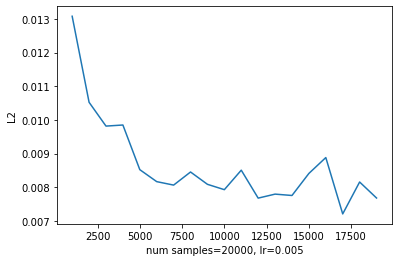

[0.013078558694571257, 0.010522845970466732, 0.009815306657925248, 0.00984750838764012, 0.008521026020869613, 0.008165258193388581, 0.00806252621859312, 0.008451648101210595, 0.008085541101172567, 0.007926826624199749, 0.008505658380687236, 0.007675630094483495, 0.007794343639165163, 0.007753857614472509, 0.008408959448337555, 0.008880616648122668, 0.0072063716519623995, 0.008154255904257297, 0.007679012324661017]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/walk_train_aug/shiftx_l2_git0.005/output/model_20000.ckpt")

[-8 -6 -5 -4 -2  0  2  4  5  6  8]


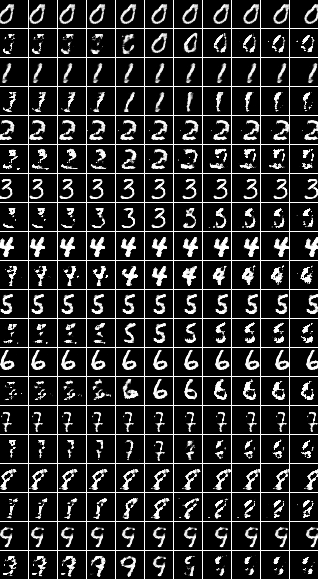

In [16]:
num_samples = 10
a = np.array([-8, -6, -5, -4, -2,  0,  2,  4,  5, 6,  8])

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained

# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -7.00, dist 0.01 +/- 0.01
alpha: -5.50, dist 0.01 +/- 0.00
alpha: -4.50, dist 0.01 +/- 0.01
alpha: -3.00, dist 0.05 +/- 0.02
alpha: -1.00, dist 0.07 +/- 0.02
alpha: 1.00, dist 0.08 +/- 0.03
alpha: 3.00, dist 0.05 +/- 0.02
alpha: 4.50, dist 0.01 +/- 0.00
alpha: 5.50, dist 0.01 +/- 0.00
alpha: 7.00, dist 0.01 +/- 0.00
2019-09-16 22:56:32,384 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-16 22:56:32,389 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


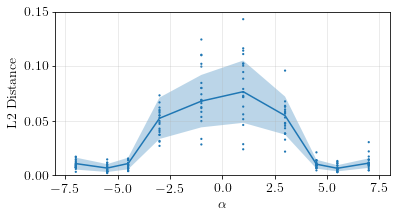

In [21]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'shiftx_NoAug_argminW_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)

alpha: -8.00, dist 0.18 +/- 0.01
alpha: -6.00, dist 0.14 +/- 0.01
alpha: -5.00, dist 0.12 +/- 0.01
alpha: -4.00, dist 0.10 +/- 0.01
alpha: -2.00, dist 0.05 +/- 0.00
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 2.00, dist 0.06 +/- 0.00
alpha: 4.00, dist 0.11 +/- 0.01
alpha: 5.00, dist 0.14 +/- 0.01
alpha: 6.00, dist 0.16 +/- 0.01
alpha: 8.00, dist 0.21 +/- 0.01


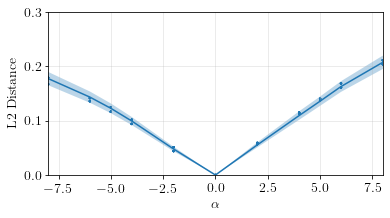

In [22]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'shiftx_NoAug_argminW_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)